In [20]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data from API

In [6]:
import os
from dotenv import load_dotenv

In [3]:
load_dotenv('./../controller/.env')


True

In [4]:
print(os.getenv("API_URL"))

https://zerofourtwo.new/api


In [12]:
# load dataset from api
headers = {"Authorization": f"Bearer {os.getenv('API_SECRET_KEY')}"}
df = pd.read_json(r'http://localhost:3000/api/dataset', storage_options=headers)

In [13]:

#df = df.query("_user == 'intotito'")
df.head()

,_id,_date,_user,fm_avg_trk_time,fm_accuracy,vx_avg_res_time,vx_shot_accuracy,vx_trg_accuracy,au_avg_res_time,bm_HR_max,bm_HR_avg,bm_HR_var,bm_act_steps,bm_sleep
0,395,2024-02-22T12:29:53.000Z,jjj,5.12871,70.5882,2.61127,35.4839,45.8333,2655.41,189.0,NaN,NaN,NaN,NaN
1,396,2024-02-22T23:25:08.000Z,jjj,2.25510,92.3077,2.49034,50.8197,67.3913,1670.35,189.0,NaN,NaN,NaN,NaN
2,397,2024-02-23T08:11:41.000Z,jjj,2.52485,85.7143,2.59793,58.9286,78.5714,1738.97,NaN,NaN,NaN,NaN,NaN
3,398,2024-02-24T07:17:55.000Z,jjj,2.67675,85.7143,2.63325,48.4375,75.6098,2147.90,NaN,58.0,68.0,NaN,3.0
4,399,2024-02-25T07:18:46.000Z,jjj,2.95700,80.0000,2.01916,58.0645,83.7209,1875.10,NaN,59.0,60.0,NaN,3.0


In [612]:
dfK = df.query("vx_shot_accuracy > 60")

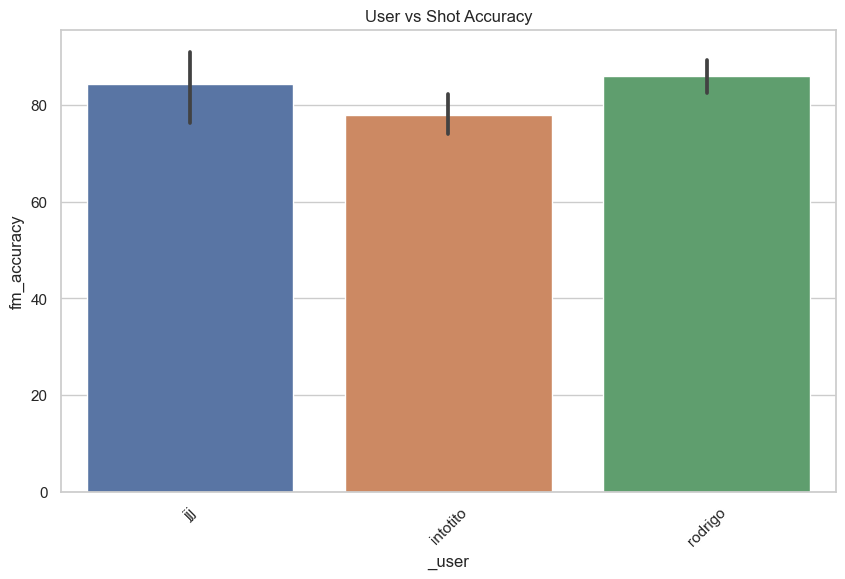

In [613]:
# plot _user vs vx_shot_accuracy
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x="_user", y="fm_accuracy", data=df)
plt.title("User vs Shot Accuracy")
plt.xticks(rotation=45)
plt.show()


# Clean Dataset

In [14]:
# delete unwanted columns
unwanted_columns = ['_id', '_date', '_user', 'bm_HR_max', 'bm_act_steps']
df_wanted = df.drop(unwanted_columns, axis=1)

In [15]:
# drop rows with missing values
df_wanted = df_wanted.dropna()
df_wanted.isna().sum()

fm_avg_trk_time     0
fm_accuracy         0
vx_avg_res_time     0
vx_shot_accuracy    0
vx_trg_accuracy     0
au_avg_res_time     0
bm_HR_avg           0
bm_HR_var           0
bm_sleep            0
dtype: int64

In [16]:
df_wanted.shape

(71, 9)

# Inspect data

In [17]:
df_wanted.head()

,fm_avg_trk_time,fm_accuracy,vx_avg_res_time,vx_shot_accuracy,vx_trg_accuracy,au_avg_res_time,bm_HR_avg,bm_HR_var,bm_sleep
3,2.67675,85.7143,2.63325,48.4375,75.6098,2147.90,58.0,68.0,3.0
4,2.95700,80.0000,2.01916,58.0645,83.7209,1875.10,59.0,60.0,3.0
6,2.05001,100.0000,2.04148,47.6190,68.1818,2211.87,61.0,77.0,3.0
8,9.32091,40.0000,2.74594,47.2222,62.9630,3254.95,59.0,71.0,4.0
10,2.24675,92.3077,1.94884,57.3770,70.0000,2017.87,60.0,61.0,4.0


In [18]:
df_wanted.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fm_avg_trk_time,71.0,2.993178,1.329409,1.25387,2.031745,2.55294,3.856535,9.32091
fm_accuracy,71.0,82.411686,11.439450,40.00000,75.000000,85.71430,92.307700,100.00000
vx_avg_res_time,71.0,2.127640,0.474956,1.35264,1.773910,2.00808,2.553015,3.10358
vx_shot_accuracy,71.0,52.757048,8.203674,39.13040,45.346300,52.54240,58.730200,73.91300
vx_trg_accuracy,71.0,83.126601,9.678706,55.55560,77.461550,85.41670,90.909100,97.91670
au_avg_res_time,71.0,2137.957887,729.176571,0.00000,1825.775000,2083.72000,2596.730000,3970.41000
bm_HR_avg,71.0,65.816901,6.961752,53.00000,61.000000,65.00000,70.000000,88.00000
bm_HR_var,71.0,44.380282,12.181211,18.00000,36.000000,42.00000,51.000000,77.00000
bm_sleep,71.0,3.676056,1.216255,1.00000,3.000000,4.00000,5.000000,6.00000


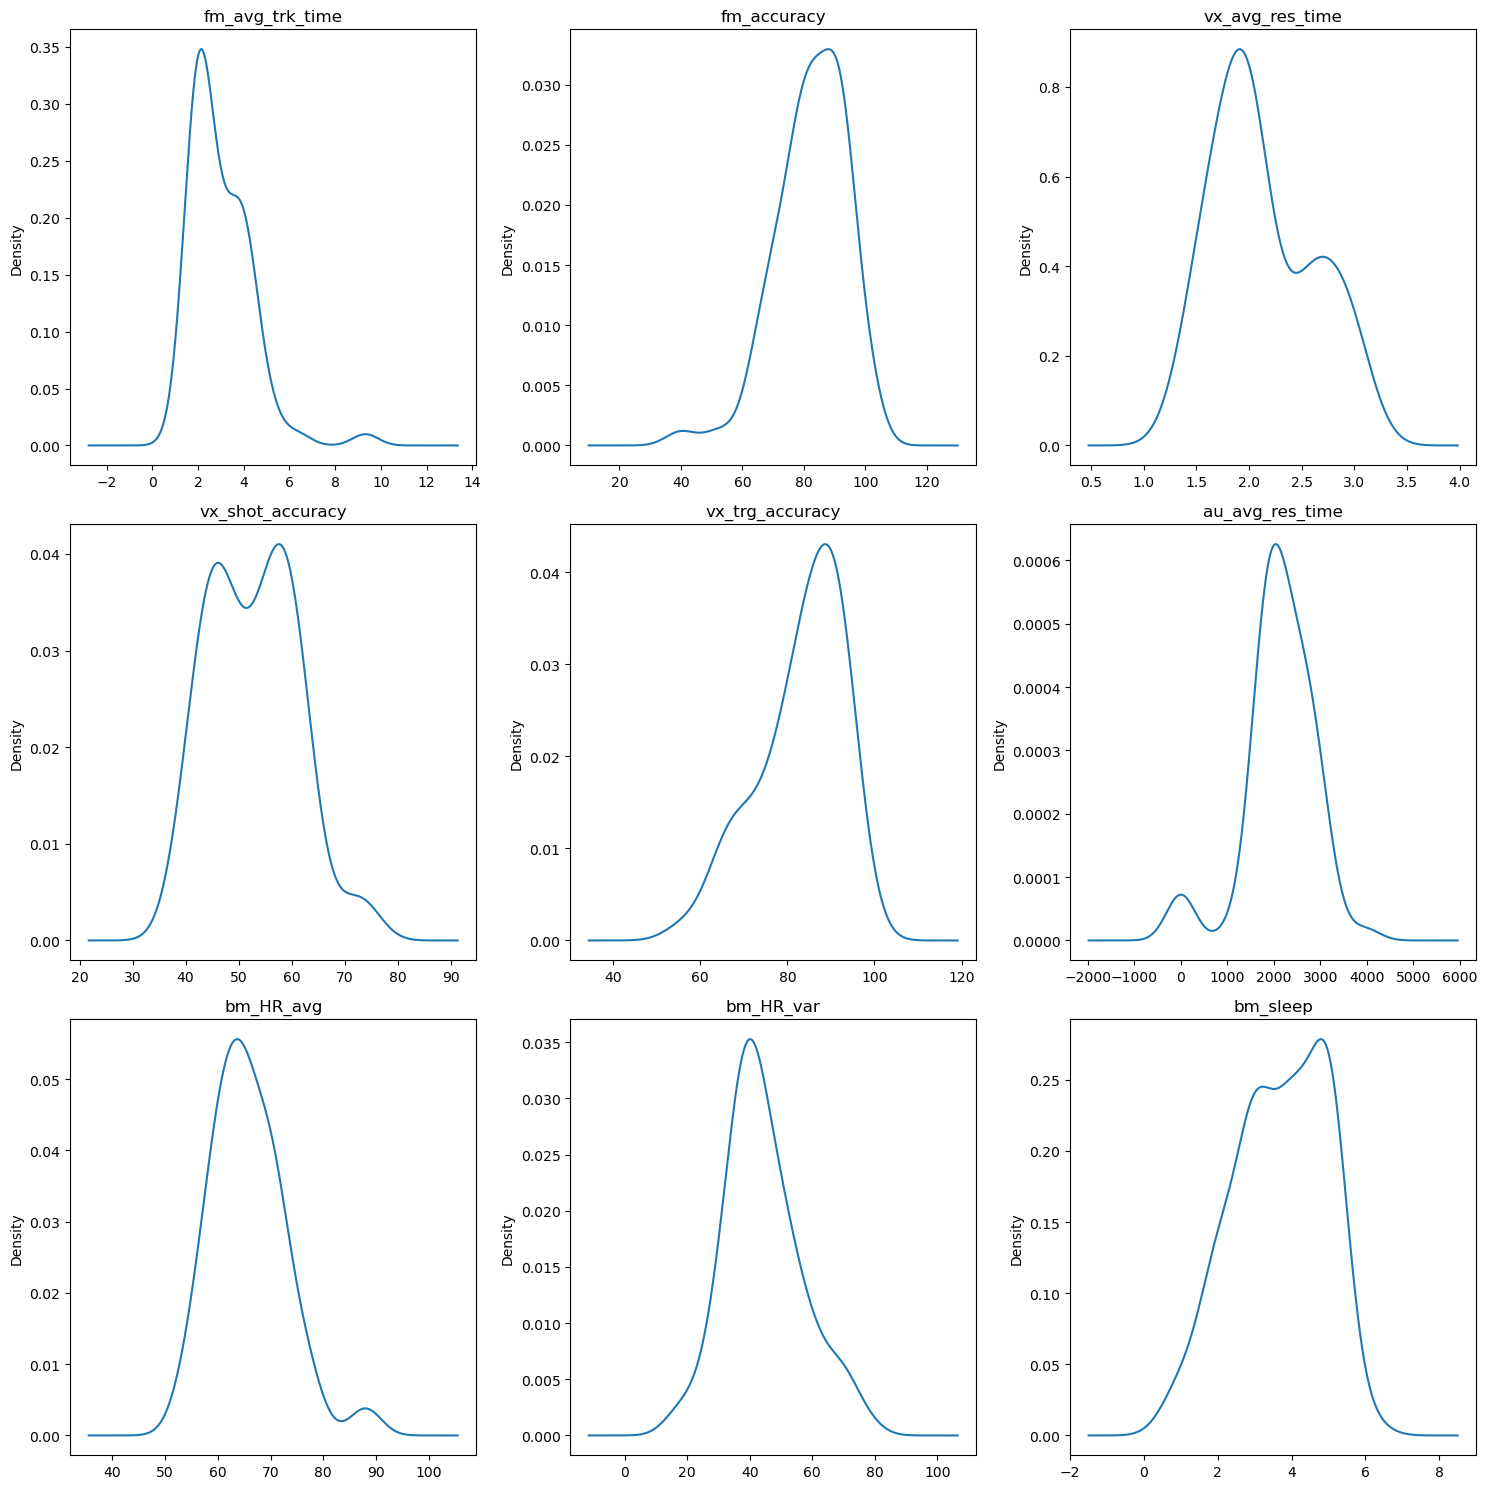

In [21]:
# plot normal distribution curve for each column using subplots
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i, column in enumerate(df_wanted.columns):
    ax = plt.subplot(3, 3, i+1)
    df_wanted[column].plot(kind='kde', ax=ax)
    ax.set_title(column)
plt.tight_layout()
plt.show()



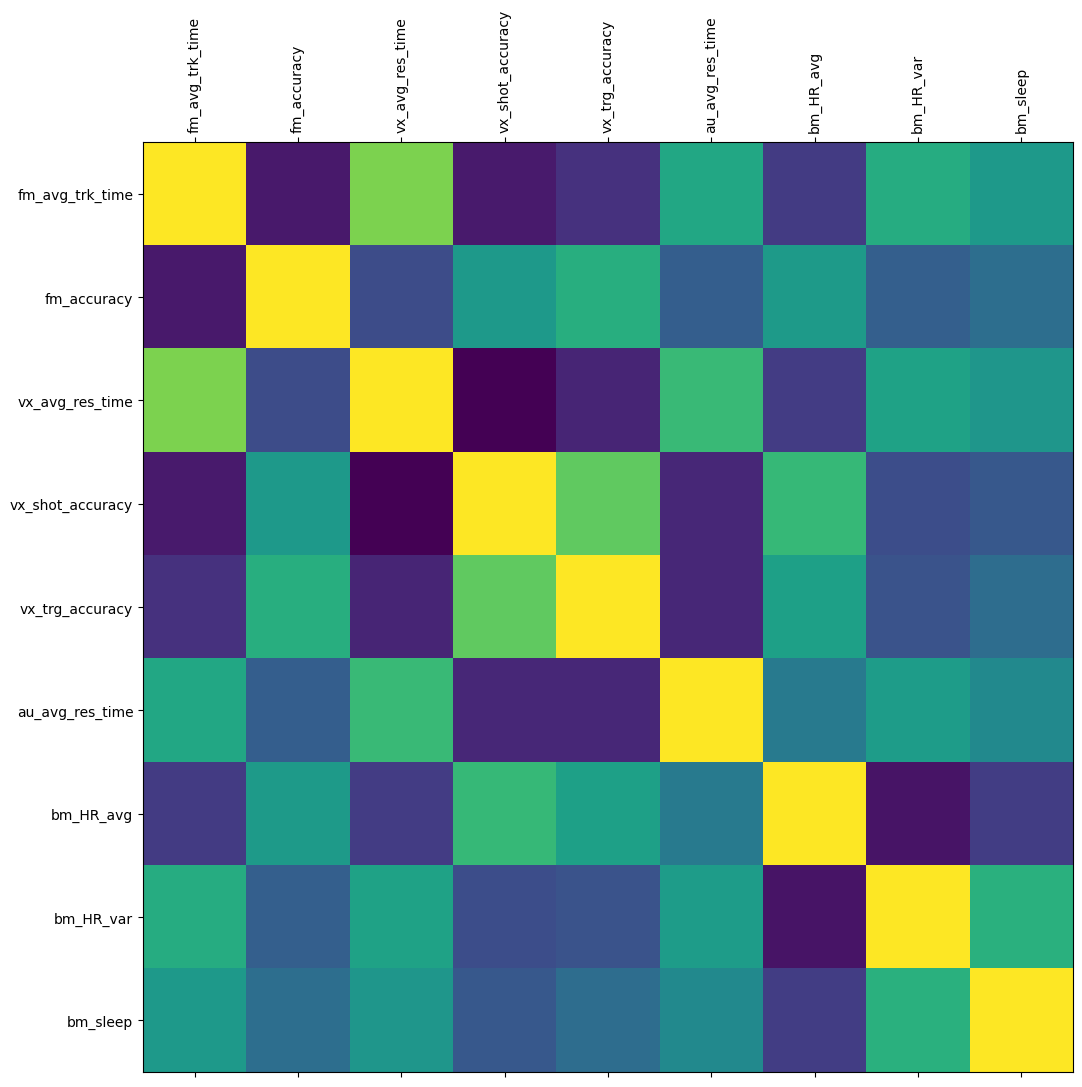

In [22]:
# show correlation matrix
correlation_matrix = df_wanted.corr()
plt.figure(figsize=(12, 12))
plt.matshow(correlation_matrix, fignum=1)
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation='vertical')
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
#plt.colorbar()
plt.show()



In [23]:
df_independent = df_wanted.iloc[:, -3:]
df_independent.shape

(71, 3)

In [24]:
df_dependent = df_wanted.iloc[:, :-3]
df_dependent.shape

(71, 6)

# Regression Model to predict vx_shot_accuracy using independent variables as input

In [25]:
# split dataset into training and testing
#from keras.models import LinearRegression
from sklearn.model_selection import train_test_split

X = df_independent
y = df_dependent

In [28]:
# scale the data
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4217)

In [30]:
X_train

array([[-0.2628409 , -0.61018657,  0.26824096],
       [ 0.89447407, -1.27161017, -1.38785538],
       [-1.2754915 ,  1.1260504 ,  1.09628912],
       [-0.40750527,  0.21659294,  1.09628912],
       [-0.11817653,  1.9528299 , -2.21590354],
       [ 0.46048096, -0.61018657, -0.55980721],
       [ 0.31581658, -0.19679681,  0.26824096],
       [-0.69683401,  0.13391499,  1.09628912],
       [ 3.20910401, -2.18106763, -1.38785538],
       [-1.85414898,  1.87015195,  0.26824096],
       [-1.56482024,  0.38194884, -0.55980721],
       [ 1.18380281,  1.20872835,  1.09628912],
       [ 3.20910401, -2.18106763, -1.38785538],
       [-0.40750527, -0.19679681,  1.09628912],
       [ 0.60514533, -0.94089837, -0.55980721],
       [ 0.31581658, -0.19679681,  0.26824096],
       [-0.11817653, -0.19679681,  0.26824096],
       [ 0.7498097 ,  0.54730474,  1.09628912],
       [-0.55216964,  0.54730474,  1.09628912],
       [ 0.7498097 ,  0.54730474,  1.09628912],
       [-0.84149838, -0.11411886,  1.096

In [34]:
# create linear regression model with 3 input and 6 output
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(3, input_dim=3, activation='tanh'))
model.add(tf.keras.layers.Dense(10, activation='tanh'))
model.add(tf.keras.layers.Dense(15, activation='tanh'))
model.add(tf.keras.layers.Dense(6, activation='tanh'))



In [36]:
# compile model
model.compile(optimizer='adam', loss='mean_squared_error')


In [37]:
# train model
model.fit(X_train, y_train, epochs=1000, batch_size=10)



Epoch 1/1000

6/6 [==============================] - 1s 4ms/step - loss: 1.2456
Epoch 2/1000
6/6 [==============================] - 0s 3ms/step - loss: 1.2148
Epoch 3/1000
6/6 [==============================] - 0s 2ms/step - loss: 1.1854
Epoch 4/1000
6/6 [==============================] - 0s 3ms/step - loss: 1.1563
Epoch 5/1000
6/6 [==============================] - 0s 2ms/step - loss: 1.1288
Epoch 6/1000
6/6 [==============================] - 0s 2ms/step - loss: 1.1049
Epoch 7/1000
6/6 [==============================] - 0s 2ms/step - loss: 1.0840
Epoch 8/1000
6/6 [==============================] - 0s 2ms/step - loss: 1.0613
Epoch 9/1000
6/6 [==============================] - 0s 2ms/step - loss: 1.0436
Epoch 10/1000
6/6 [==============================] - 0s 3ms/step - loss: 1.0265
Epoch 11/1000
6/6 [==============================] - 0s 2ms/step - loss: 1.0129
Epoch 12/1000
6/6 [==============================] - 0s 3ms/step - loss: 1.0004
Epoch 13/1000
6/6 [=============================

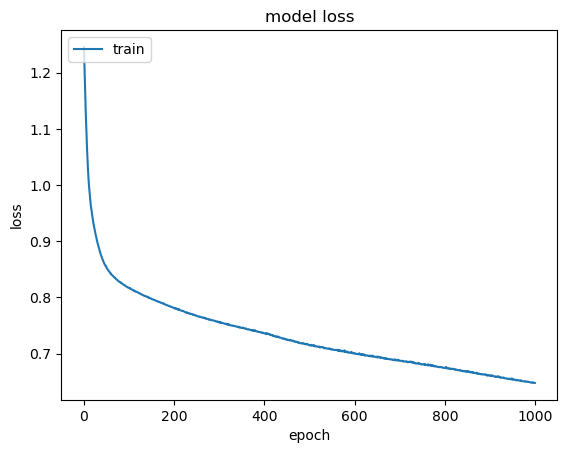

In [38]:
# plot training and validation loss
plt.plot(model.history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [39]:
# calculate r2 score
from sklearn.metrics import r2_score
y_pred = model.predict(X_test)
r2_score(y_test, y_pred)



1/1 [==============================] - 0s 106ms/step


0.09635847790765352

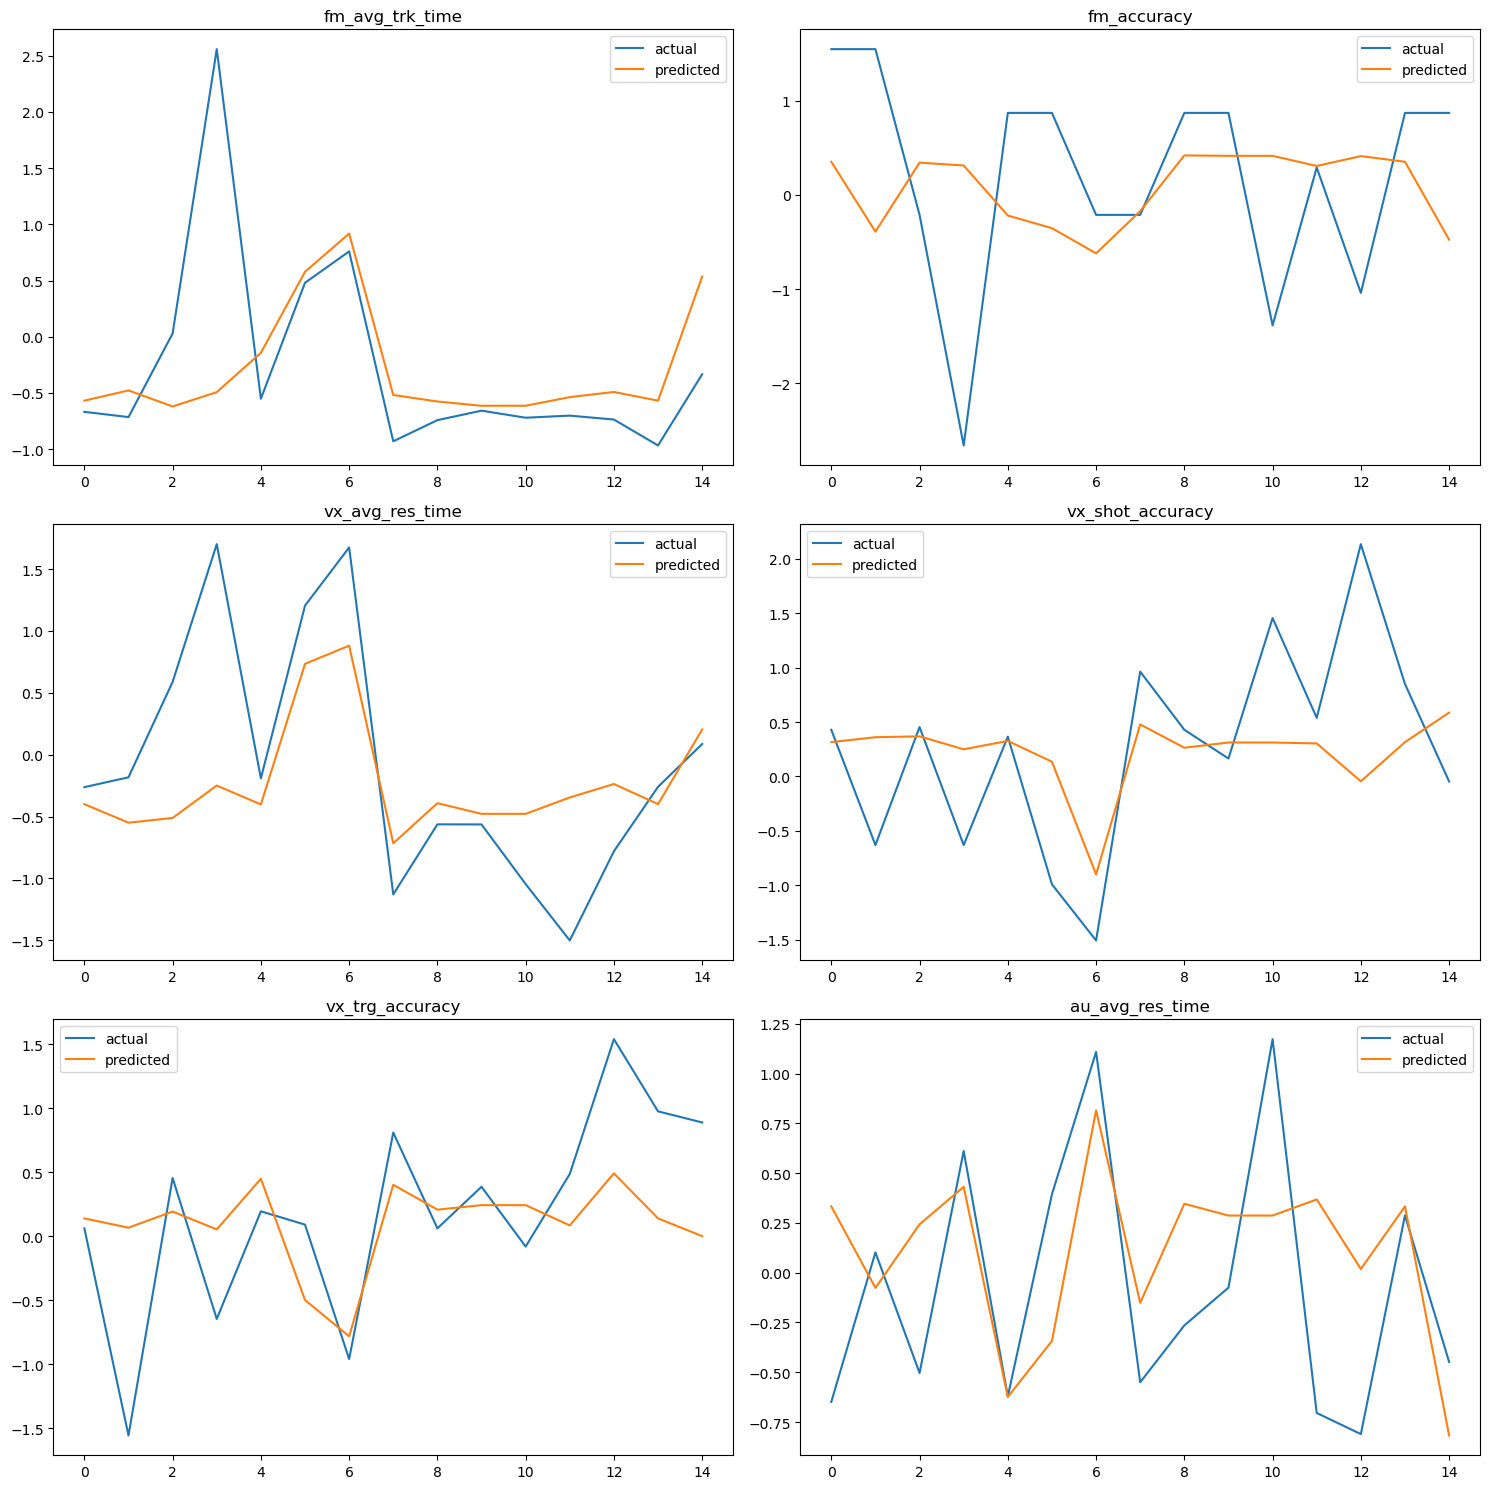

In [40]:
# plot actual vs predicted for each column
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
for i, column in enumerate(df_dependent.columns):
    ax = plt.subplot(3, 2, i+1)
    ax.plot(y_test[:, i], label='actual')
    ax.plot(y_pred[:, i], label='predicted')
    ax.set_title(column)
    ax.legend()
plt.tight_layout()
plt.show()

In [41]:
# evaluate r2 score for the model
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)


0.09635847790765352

In [42]:
# evaluate r2 score for training data
y_pred_train = model.predict(X_train)
r2_score(y_train, y_pred_train)


2/2 [==============================] - 0s 4ms/step


0.3776546966006928

3/3 [==============================] - 0s 0s/step


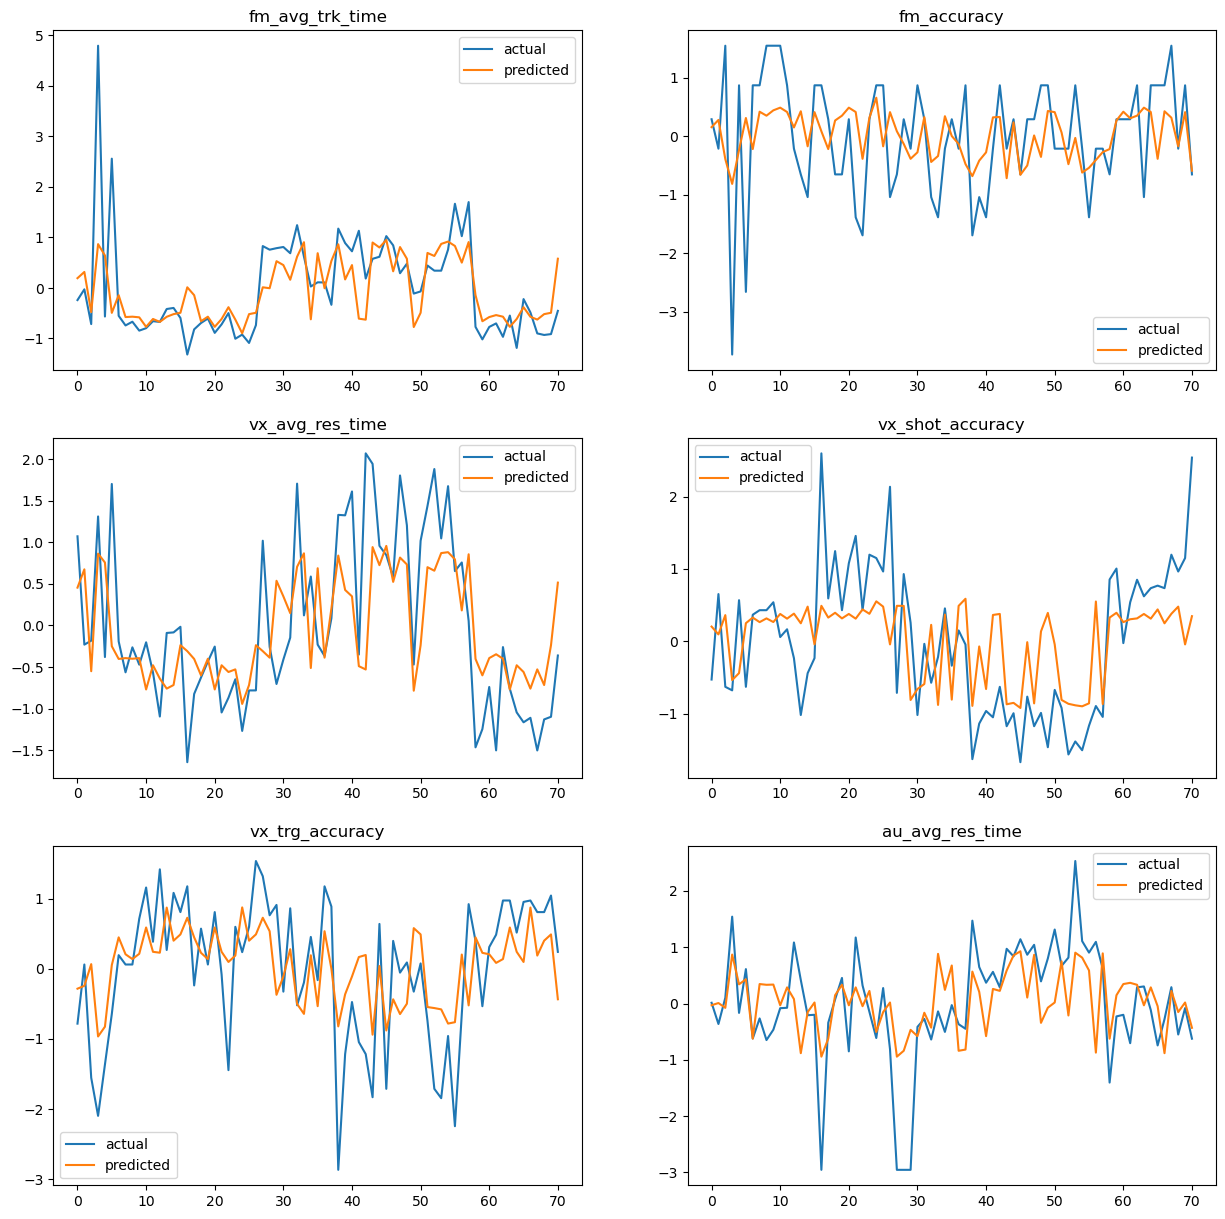

In [43]:
# evaluate prediction for all data
y_pred_all = model.predict(X)
r2_score(y, y_pred_all)

# plot actual vs predicted for each column
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
for i, column in enumerate(df_dependent.columns):
    ax = plt.subplot(3, 2, i+1)
    ax.plot(y[:, i], label='actual')
    ax.plot(y_pred_all[:, i], label='predicted')
    ax.set_title(column)
    ax.legend()
plt.show()





In [44]:
# calculate r2 score for each output displaying label of columns
r2_scores = []
for i, column in enumerate(df_dependent.columns):
    r2 = r2_score(y[:, i], y_pred_all[:, i])
    r2_scores.append((column, r2))
r2_scores



[('fm_avg_trk_time', 0.383748825421233),
 ('fm_accuracy', 0.13161063352415103),
 ('vx_avg_res_time', 0.4038026257037096),
 ('vx_shot_accuracy', 0.3205347592124719),
 ('vx_trg_accuracy', 0.41286450253525575),
 ('au_avg_res_time', 0.33914542450239027)]